# 프로젝트: 뉴스기사 요약해보기

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas

print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1. 데이터 수집하기

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
43244,United flight diverted after dog placed on wro...,A Newark-Missouri United Airlines flight was d...
29143,What do trolls expect me to wear while swimmin...,"Malaika Arora, who got trolled last week for p..."
16815,Trump praises 'exciting' agreements by Kim Jon...,US President Donald Trump on Wednesday praised...
7080,"EVM machine found lying on road in Rajasthan, ...",An EVM machine was found lying unattended on t...
92645,Henry Cavill's look from Mission: Impossible 6...,Actor Henry Cavill's look from the upcoming ac...
3794,Trucking startup Fortigo to raise $50mn to ent...,Bengaluru-based trucking logistics startup 4Ti...
5323,Sachin Bansal registers new company after $1 b...,"Flipkart Co-founder Sachin Bansal, along with ..."
5266,Police busts call centre in Noida duping US ci...,The Noida Police has arrested 126 people after...
62053,Tejashwi took loan from liquor manufacturer: S...,Bihar Deputy CM Sushil Modi on Tuesday alleged...
98073,4 crore tourists visited Rajasthan in 2016: St...,Rajasthan's Rural Development Minister Rajendr...


# Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

In [5]:
data.shape

(98401, 2)

In [6]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [7]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


## 텍스트 정규화와 불용어 제거

- 직접 눈으로 단어를 몇개 보면서 전처리 방식을 수정하였다.
-  '&' -> ' and '로,  \' -> '로 교체
- A&B일 경우를 고려해 ' and '로 전처리 한것을 감안해 다중 공백 제거하는 전처리를 추가하였다
- 불용어는 no나 not 같은 부정어들까지 사라지게 하므로 일단은 불용어는 제거하지 않았다

In [9]:
data.sample(5)

,headlines,text
24965,Balika Vadhu actor arrested as his BMW hits 3 ...,"TV actor Siddharth Shukla, known for his role ..."
66746,Paper plane thrown from stands soars into goal...,A paper plane soared into the goal during an E...
80861,White House strongly condemns Amarnath terror ...,The White House has strongly condemned the ter...
56326,Two killed as Tamil Nadu Governor's convoy run...,Two people were killed and two others were inj...
97508,No association of missing JNU student with IS:...,The Delhi Police on Tuesday rubbished media re...


In [10]:
data.headlines.sample(5).tolist()

['WeWork to be valued at $35 billion, more than Airbnb, SpaceX',
 'NASA sends 1st man-made object between Saturn and its rings',
 'Delhi Police tweets picture of its first wireless set',
 'Kept promise made to victim: Cops who probed Nirbhaya case',
 '40 HIV cases found after locals treated with common syringe']

In [11]:
data.text.sample(5).tolist()

['Italian neurosurgeon Sergio Canavero, famed for his plans to perform the first human head transplant, has now claimed to have severed spinal cords of 15 mice which were then surgically reattached. Nine mice, reconnected with a special "glue" were able to move after 28 days while six mice treated with saline didn\'t recover. However, all mice died within a month.',
 'Miss Moscow 2015 Oksana Voevodina got married to 49-year-old Malaysian King Sultan Muhammad V reportedly in Russia last week. The wedding held in the Russian capital of Moscow incorporated both Islamic and Russian traditions, according to reports. Voevodina had converted to Islam and changed her name earlier this year, reports added.',
 'Nineteen-time Grand Slam champion Roger Federer took to Twitter to congratulate his hometown club FC Basel on its victory in the Champions League against Manchester United. "Words can\'t possibly describe this incredible moment for this club, wow!!!! Congrats to the team," Federer wrote. 

In [12]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [13]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [14]:
stop_words = stopwords.words('english')

stop_words.remove('no')
stop_words.remove('not')

In [16]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very',

In [17]:
from tqdm import tqdm, trange

tqdm.pandas()

In [22]:
# 데이터 전처리 함수

def preprocess_sentence(sentence, remove_stopwords=True, stopwords=[]):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('\"','', sentence) # 쌍따옴표 " 제거
    
    sentence = re.sub("&"," and ", sentence) # & -> and로 교체
    sentence = re.sub("\'","'", sentence) # \' -> '로 교체
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    sentence = re.sub(' +', ' ', sentence) # 다중공백 제거
    # sentence = ' '.join(sentence.split())
     
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

불용어에 no, not 같은 단어들이 있어서 일단 불용어는 제거하지 않는다
- stopwords 적용을 안하니 성능이 너무 좋지 않아 제거하고자 한다

In [24]:
clean_text = data['text'].progress_apply(lambda x: preprocess_sentence(x, remove_stopwords=True, stopwords=stop_words)).tolist()

print("text 전처리 후 결과: ", clean_text[:5])

100%|██████████| 98360/98360 [00:33<00:00, 2965.02it/s]

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [25]:
clean_headlines = data['headlines'].progress_apply(lambda x: preprocess_sentence(x, remove_stopwords=True, stopwords=stop_words)).tolist()

print("headline 전처리 후 결과: ", clean_headlines[:5])

100%|██████████| 98360/98360 [00:19<00:00, 4938.30it/s]

headline 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims not true sonam']


In [26]:
# 원본을 news에 저장해두고 오류 발생시 다시 사용하고자 한다
news = data.copy()

In [27]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [28]:
news

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [29]:
data.head()

,headlines,text
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,known hirani yrs metoo claims not true sonam,speaking sexual harassment allegations rajkuma...


In [30]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.38986376575844
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.210014233428223


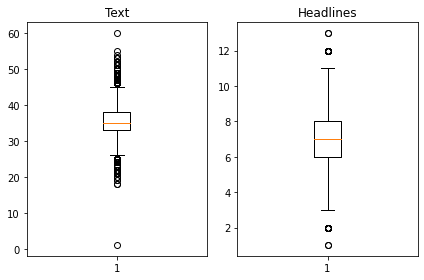

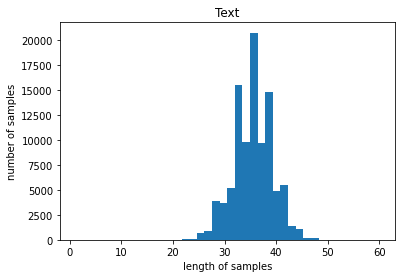

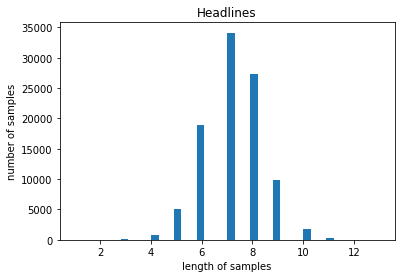

In [31]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 이상치 제거

In [32]:
np.argmin(text_len)

52

In [33]:
data.iloc[52]

headlines    headlines
text              text
Name: 52, dtype: object

In [34]:
np.quantile(text_len, 0.25)

33.0

In [35]:
data.shape

(98360, 2)

In [36]:
data.drop(52, inplace=True)

In [37]:
data.shape

(98359, 2)

In [40]:
np.argmin(summary_len)

26210

In [41]:
data.iloc[np.argmin(summary_len)]

headlines                              friggatriskaidekaphobia
text         friggatriskaidekaphobia person irrational fear...
Name: 26212, dtype: object

텍스트의 최소 길이 : 18
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.3902134019256
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.210077369635722


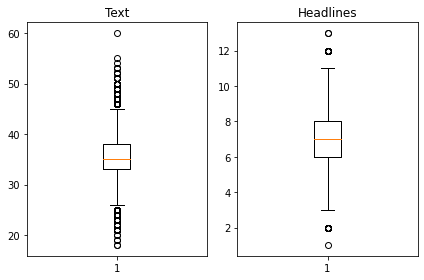

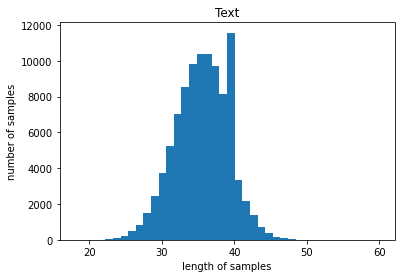

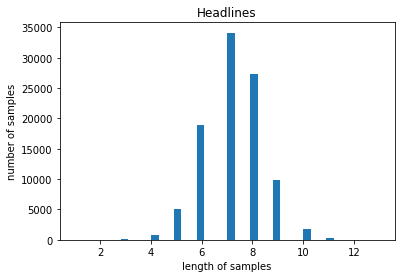

In [38]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [42]:
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))

텍스트의 최대 길이 : 60
요약의 최대 길이 : 13


In [43]:
text_max_len = 50
summary_max_len = 10

In [44]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [45]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998474974328735
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.9973566221698065


### text_max_len과 summary_max_len의 길이보다 큰 샘플을 제외

In [46]:
data.shape

(98359, 2)

In [47]:
c1 = data['headlines'].apply(lambda x: len(x.split())) <= summary_max_len
c2 = data['text'].apply(lambda x: len(x.split())) <= text_max_len

data = data.loc[c1 & c2]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98086


### 시작 토큰과 종료 토큰 추가하기

In [48]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims not true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims not tru...,known hirani yrs metoo claims not true sonam e...


In [49]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [50]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[90743 24237 57473 ... 70099  8854 32320]


In [51]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [52]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19617


In [53]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78469
훈련 레이블의 개수 : 78469
테스트 데이터의 개수 : 19617
테스트 레이블의 개수 : 19617


### 정수 인코딩

In [54]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train)

In [55]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69392
등장 빈도가 6번 이하인 희귀 단어의 수: 47239
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22153
단어 집합에서 희귀 단어의 비율: 68.07557067097072
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.450304490551138


In [56]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [57]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2327, 12, 1330, 290, 3018, 1801, 21, 4335, 1360, 9837, 14269, 8989, 743, 1801, 6460, 12, 1330, 5696, 224, 457, 56, 546, 1043, 1330, 13816, 5697, 257], [89, 10, 2859, 835, 160, 61, 13361, 1541, 6056, 4199, 63, 603, 87, 230, 3235, 9154, 3164, 2751, 1, 835, 7, 100, 1276, 2751, 1, 10945, 757, 5513, 1276, 128, 208, 304, 774, 3703, 345, 12185, 976], [6109, 129, 2337, 277, 26, 823, 181, 8378, 717, 123, 894, 1808, 400, 85, 231, 1670, 15977, 169, 1038, 262, 277, 5091, 1866, 5989, 894, 4097, 486, 107, 277, 26, 823, 181, 8378, 12186, 1841, 69, 133, 266]]


In [58]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [59]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29888
등장 빈도가 5번 이하인 희귀 단어의 수: 19645
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10243
단어 집합에서 희귀 단어의 비율: 65.72872055674517
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.854673967921084


In [60]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 13, 1889, 55, 488, 2519, 6724, 5068], [1, 8, 489, 63, 6725, 6726, 1119, 4131], [1, 5, 161, 217, 757, 1277, 1948, 199, 798], [1, 497, 358, 3, 316, 329, 2467, 4909, 1227], [1, 128, 13, 95, 2380, 1034, 483, 364]]
target
decoder  [[13, 1889, 55, 488, 2519, 6724, 5068, 2], [8, 489, 63, 6725, 6726, 1119, 4131, 2], [5, 161, 217, 757, 1277, 1948, 199, 798, 2], [497, 358, 3, 316, 329, 2467, 4909, 1227, 2], [128, 13, 95, 2380, 1034, 483, 364, 2]]


In [61]:
decoder_target_test[:5]

[[601, 851, 301, 823, 1044, 225, 2548, 2],
 [536, 1648, 3235, 1919, 9241, 9057, 2],
 [484, 1622, 3282, 42, 27, 23, 189, 2],
 [5021, 1586, 234, 56, 419, 4610, 474, 2],
 [2722, 343, 1803, 301, 148, 1439, 79, 66, 2]]

In [62]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 2
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78467
훈련 레이블의 개수 : 78467
테스트 데이터의 개수 : 19617
테스트 레이블의 개수 : 19617


### 패딩하기

pre로 하면 어떻게 될까?

In [63]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 모델 설계하기

- __모델 선정 이유__ 
    - lstm은 자연어 처리에서 대체로 좋은 성능을 내므로 lstm모델을 선정했고
    - 요약 모델을 할때 seq2seq를 사용하므로 이를 활용하였고 
    - attention은 lstm의 long term dependency 문제를 해결하기 위해 활용하였다
    
- __Metrics 선정 이유__
    - 요약 모델의 평가시 Rouge score를 많이 활용한다하여 이를 사용해보고자 하였으나 시간상의 이유로 활용하지 못했고
    - 대신에 직접 샘플을 통해 비교를 진행하였다
    
- __Loss 선정 이유__ 
    - sparse categorical crossentropy
    - seq2seq는 결국 10000개의 단어중에서 다음 단어를 예측하는 문제로 바뀌므로 이에따라 sparse categorical crossentropy를 선정하였다

In [64]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

디코더 설계

In [65]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [66]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [67]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [68]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 62s 93ms/step - loss: 5.6394 - val_loss: 5.2168
Epoch 2/50
307/307 [==============================] - 28s 92ms/step - loss: 5.0794 - val_loss: 4.8365
Epoch 3/50
307/307 [==============================] - 29s 95ms/step - loss: 4.7579 - val_loss: 4.6212
Epoch 4/50
307/307 [==============================] - 30s 98ms/step - loss: 4.5092 - val_loss: 4.4329
Epoch 5/50
307/307 [==============================] - 30s 98ms/step - loss: 4.2973 - val_loss: 4.2880
Epoch 6/50
307/307 [==============================] - 30s 97ms/step - loss: 4.1210 - val_loss: 4.1994
Epoch 7/50
307/307 [==============================] - 30s 98ms/step - loss: 3.9690 - val_loss: 4.0997
Epoch 8/50
307/307 [==============================] - 30s 98ms/step - loss: 3.8367 - val_loss: 4.0283
Epoch 9/50
307/307 [==============================] - 30s 98ms/step - loss: 3.7163 - val_loss: 3.9738
Epoch 10/50
307/307 [==============================] - 30s 98ms/step - loss: 3.613

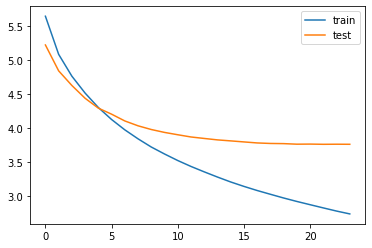

In [69]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- 그래프를 통해 train loss와 val loss가 감소하는 것을 볼 수 있다

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [70]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [71]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [72]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [73]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence.strip()

모델 테스트하기

In [74]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i>2):
            temp = temp + tar_index_to_word[i]+' '
    return temp.strip()

In [87]:
len(encoder_input_test)

19617

In [75]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : germany based ceo thursday offered resign days hailed historic merger firm steel making business india tata steel form joint venture asked supervisory board company end mandate ceo mutual agreement merger create europe second largest steelmaker arcelormittal 
실제 요약 : ceo offers resign days tata steel deal
예측 요약 : tata steel ceo quits india chairman


원문 : vice president venkaiah naidu saturday said google important could never replace place guru lives students adding students work serve mother mother tongue said india great heritage feel proud great indian culture 
실제 요약 : google cannot replace guru vice president venkaiah naidu
예측 요약 : google vp naidu class vp


원문 : denying rumours making biopic late actress sridevi filmmaker ram gopal verma said believe foolish attempt also cannot actress remotely worthy enough play late actress worked ram gopal varma telugu film 
실제 요약 : no actress enough play sridevi biopic rgv
예측 요약 : actress slams husband raj


원문 : russia pakistan monday b

In [76]:
encoder_input_test.shape

(19617, 50)

In [88]:
summerize_test = []
for i in trange(len(encoder_input_test)):
    tmp = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
    summerize_test.append(tmp)

- stopwords를 제거하지 않았더니 상당히 잘 요약하는 것으로 보인다
- 모든 test_data를 번역한 뒤에 이를 활용해서 ROUGE SCORE를 구해보려 했으나 시간이 너무 오래 걸려서 하지 못했다

In [78]:
len(summerize_test)

2955

### Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

- 너무 적은 문장의 경우에는 요약을 못한다

In [81]:
import requests
from summa.summarizer import summarize

In [82]:
text = news.text[0]

In [83]:
text

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [84]:
print('Summary:')
print(summarize(text, words=15))

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [85]:
news['summa_summarize'] = news['text'].progress_apply(lambda x: summarize(x, words=15))

100%|██████████| 98360/98360 [01:41<00:00, 969.38it/s] 


In [86]:
news['summa_summarize'].iloc[-n_of_val:]

78779    Workers of Vivo phone factory on Tuesday prote...
78780    A London office asked employees to wrap their ...
78781    Senior Lawyer Ram Jethmalani has quit as Delhi...
78782    Air India has grounded two female pilots after...
78783    Niti Aayog cited Air India's "fragile finances...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    Michael B Jordan will reportedly play the lead...
98399    The video also shows a TV airing a news confer...
98400                                                     
Name: summa_summarize, Length: 19617, dtype: object

In [89]:
news.shape

(98360, 3)

In [90]:
data.shape

(98086, 4)

In [91]:
all_data = data.merge(news, how='left', right_index=True, left_index=True, suffixes=['','_raw'])

In [92]:
all_data.shape

(98086, 7)

In [93]:
test_data = all_data.iloc[-n_of_val:]

In [94]:
samples = test_data.sample(10)

In [95]:
samples

,headlines,text,decoder_input,decoder_target,headlines_raw,text_raw,summa_summarize
83552,oracle founder larry ellison gets bn richer days,american computer technology major oracle year...,sostoken oracle founder larry ellison gets bn ...,oracle founder larry ellison gets bn richer da...,Oracle Founder Larry Ellison gets $5 bn richer...,American computer technology major Oracle's 72...,American computer technology major Oracle's 72...
79626,eat tv bitcoin not hit cr mcafee,founder mcafee anti virus software john mcafee...,sostoken eat tv bitcoin not hit cr mcafee,eat tv bitcoin not hit cr mcafee eostoken,I'll eat my d**k on TV if Bitcoin doesn't hit ...,Founder of McAfee anti-virus software John McA...,
83739,two friends indore grab india ranks neet,two friends archit gupta manish mulchandani in...,sostoken two friends indore grab india ranks neet,two friends indore grab india ranks neet eostoken,Two friends from Indore grab All India Ranks 2...,Two friends Archit Gupta and Manish Mulchandan...,Both Gupta and Mulchandani left their homes to...
97467,merger idea not reliance jio vodafone ceo,vodafone ceo vittorio colao responding questio...,sostoken merger idea not reliance jio vodafone...,merger idea not reliance jio vodafone ceo eost...,Merger with Idea not because of Reliance Jio: ...,"Vodafone CEO Vittorio Colao, while responding ...",
93527,man says dragged plane worse fleeing vietnam,passenger dragged united airlines flight said ...,sostoken man says dragged plane worse fleeing ...,man says dragged plane worse fleeing vietnam e...,Man says being dragged off plane worse than fl...,The passenger who was dragged from a United Ai...,
86689,pichai disappointed us pulling paris agreement,google ceo sundar pichai friday took twitter t...,sostoken pichai disappointed us pulling paris ...,pichai disappointed us pulling paris agreement...,Pichai 'disappointed' with US pulling out of P...,Google CEO Sundar Pichai on Friday took to Twi...,Google CEO Sundar Pichai on Friday took to Twi...
87748,indian forced pak man marry allowed return,islamabad high court allowed uzma indian woman...,sostoken indian forced pak man marry allowed r...,indian forced pak man marry allowed return eos...,Indian who was forced by Pak man to marry allo...,"The Islamabad High Court has allowed Uzma, the...","The Islamabad High Court has allowed Uzma, the..."
86426,raised block refugee rescue missions sea,members anti islam anti immigrant identitarian...,sostoken raised block refugee rescue missions sea,raised block refugee rescue missions sea eostoken,"Over ÃÂ£50,000 raised to block refugee rescue...",Members of the anti-Islam and anti-immigrant '...,
97993,modi govt build toilets madrassas minister,union minister mukhtar abbas naqvi saturday sa...,sostoken modi govt build toilets madrassas min...,modi govt build toilets madrassas minister eos...,Modi govt to build toilets in 1L madrassas by ...,Union Minister Mukhtar Abbas Naqvi on Saturday...,Union Minister Mukhtar Abbas Naqvi on Saturday...
86229,kapil replies fan query sunil returning show,comedian kapil sharma responding fan query sun...,sostoken kapil replies fan query sunil returni...,kapil replies fan query sunil returning show e...,Kapil replies to fan's query on Sunil returnin...,"Comedian Kapil Sharma, while responding to a f...",


# 테스트

- raw 문장에서 한번에 예측까지 하는 함수를 만들었고 이를 활용하여 전체 예측과정을 수행하였다
- 완전 새로운 뉴스데이터를 가져오려하였으나 용량 및 길이등의 문제로 test data(validation) 에서 샘플링을 하였다

In [96]:
def make_summary(text):
    pp = preprocess_sentence(text, False)
    ppd = src_tokenizer.texts_to_sequences([pp])
    ps = pad_sequences(ppd, maxlen=text_max_len, padding='post')
    result = decode_sequence(ps.reshape(1, text_max_len))
    return result

In [97]:
results = []
for text in samples.text_raw:
    result = make_summary(text)
    results.append(result)

In [98]:
samples['summary'] = results

In [99]:
samples.head()

,headlines,text,decoder_input,decoder_target,headlines_raw,text_raw,summa_summarize,summary
83552,oracle founder larry ellison gets bn richer days,american computer technology major oracle year...,sostoken oracle founder larry ellison gets bn ...,oracle founder larry ellison gets bn richer da...,Oracle Founder Larry Ellison gets $5 bn richer...,American computer technology major Oracle's 72...,American computer technology major Oracle's 72...,net net worth crore yr
79626,eat tv bitcoin not hit cr mcafee,founder mcafee anti virus software john mcafee...,sostoken eat tv bitcoin not hit cr mcafee,eat tv bitcoin not hit cr mcafee eostoken,I'll eat my d**k on TV if Bitcoin doesn't hit ...,Founder of McAfee anti-virus software John McA...,,bitcoin could hit bn due power mcafee
83739,two friends indore grab india ranks neet,two friends archit gupta manish mulchandani in...,sostoken two friends indore grab india ranks neet,two friends indore grab india ranks neet eostoken,Two friends from Indore grab All India Ranks 2...,Two friends Archit Gupta and Manish Mulchandan...,Both Gupta and Mulchandani left their homes to...,india jee main
97467,merger idea not reliance jio vodafone ceo,vodafone ceo vittorio colao responding questio...,sostoken merger idea not reliance jio vodafone...,merger idea not reliance jio vodafone ceo eost...,Merger with Idea not because of Reliance Jio: ...,"Vodafone CEO Vittorio Colao, while responding ...",,not believe vodafone idea vodafone idea vodafo...
93527,man says dragged plane worse fleeing vietnam,passenger dragged united airlines flight said ...,sostoken man says dragged plane worse fleeing ...,man says dragged plane worse fleeing vietnam e...,Man says being dragged off plane worse than fl...,The passenger who was dragged from a United Ai...,,man united flight


In [100]:
for i in range(10):
    print("원문 :", samples.text_raw.tolist()[i])
    print("실제 요약 :", samples.headlines.tolist()[i])
    print("예측 요약 :", samples.summary.tolist()[i])
    print("추출적 요약 :", samples.summa_summarize.tolist()[i])
    print("\n")

원문 : American computer technology major Oracle's 72-year-old Co-founder, Larry Ellison's net worth has jumped by $5 billion in two days to hit $61.8 billion. The jump in his net worth came from his around 25% stake in Oracle, after his company's shares soared following fourth-quarter earnings that exceeded analysts' expectations. Ellison is currently the seventh richest person in the world.
실제 요약 : oracle founder larry ellison gets bn richer days
예측 요약 : net net worth crore yr
추출적 요약 : American computer technology major Oracle's 72-year-old Co-founder, Larry Ellison's net worth has jumped by $5 billion in two days to hit $61.8 billion.


원문 : Founder of McAfee anti-virus software John McAfee has tweeted that he will "eat his d**k on national television" if the price of Bitcoin doesn't cross $500,000 (about Ã¢ÂÂ¹3.2 crore) in three years. The digital currency Bitcoin reached a high of $3,018 in mid-June but dropped below $2,000 over the past weekend. The overall cryptocurrency market h

In [104]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=f4307acb44d2e63a4f0e4b7ae7b9063ec70c9652b4979ecc3d1d2070e67a9e4d
  Stored in directory: /aiffel/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge-score


In [105]:
from rouge_score import rouge_scorer

In [106]:
reference_summaries = samples.headlines.tolist()
generated_summaries = samples.summary.tolist()

In [107]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for ref, gen in zip(reference_summaries, generated_summaries):
    scores = scorer.score(ref, gen)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

print("Average ROUGE-1: ", np.mean(rouge1_scores))
print("Average ROUGE-2: ", np.mean(rouge2_scores))
print("Average ROUGE-L: ", np.mean(rougeL_scores))

Average ROUGE-1:  0.25267399267399265
Average ROUGE-2:  0.03356643356643356
Average ROUGE-L:  0.21076923076923076


In [87]:
len(encoder_input_test)

19617

In [110]:
len(encoder_input_test)

19617

In [112]:
reference_summaries = []
generated_summaries = []

for i in trange(200, 300):
    real = seq2summary(decoder_input_test[i])
    generated = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
    
    reference_summaries.append(real)
    generated_summaries.append(generated)

100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


In [113]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for ref, gen in zip(reference_summaries, generated_summaries):
    scores = scorer.score(ref, gen)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

print("Average ROUGE-1: ", np.mean(rouge1_scores))
print("Average ROUGE-2: ", np.mean(rouge2_scores))
print("Average ROUGE-L: ", np.mean(rougeL_scores))

Average ROUGE-1:  0.2404473990062225
Average ROUGE-2:  0.05579584304584304
Average ROUGE-L:  0.21722366195895604


# 결과

### 결과 해석 (stopwords 적용전)
- Average ROUGE-1: 0.101
- Average ROUGE-2: 0.0105
- Average ROUGE-L: 0.089

### 눈으로 보고 결과 확인하기

- 원문 : The Union government on Monday launched 'e-CinePramaan', the Online Film Certification System of the Central Board of Film Certification. This will make the process for films to obtain a certificate fully digital and will include QR Codes to check fraudulent certificates. "A highlight of online film certification is elimination of middlemen and of corruption," said I&B Minister M Venkaiah Naidu.
- 실제 요약 : govt launches online film certification system
- 예측 요약 : govt to sell child accident in delhi ncr
-----
- 원문 : India is currently drafting a policy to safeguard its interests in Antarctica and will most likely present it at the winter session of the Parliament, reports said. Being a consultative member of the Antarctic Treaty, it is important for India to have clear directives to guide its activities in the region, officials said.
- 실제 요약 : india to draft law to safeguard interests in antarctica
- 예측 요약 : india to be part of doing business due to lack of hotels

### 결과 해석 (stopwords 적용결과)

#### Average ROUGE-1: 0.2527

    - 해석: 생성된 요약에서 참조 요약과 단어 단위로 25.27% 일치합니다.
    - 의미: 단어 단위로 약 25.27%의 단어가 참조 요약과 일치한다는 것을 의미합니다. 
        - 이는 비교적 적당한 일치율로, 생성된 요약이 참조 요약과 단어 수준에서 어느 정도 유사성을 가지고 있음을 나타냅니다.

#### Average ROUGE-2: 0.0336

    - 해석: 생성된 요약에서 참조 요약과 2-그램(단어 쌍) 단위로 3.36% 일치합니다.
    - 의미: 2-그램의 일치율이 3.36%로, 생성된 요약이 참조 요약과의 문장 구조나 연속된 단어 쌍을 비교적 낮게 반영하고 있음을 의미합니다. 
        - 이는 문장 구조와 어순에서 참조 요약과의 유사성이 낮음을 시사합니다.

#### Average ROUGE-L: 0.2108

    - 해석: 생성된 요약에서 참조 요약과 최장 공통 부분열(Longest Common Subsequence, LCS) 단위로 21.08% 일치합니다.
    - 의미: LCS 기반의 일치율이 21.08%라는 것은, 생성된 요약이 참조 요약과 긴 부분열에서 어느 정도 일치하는 경우가 있다는 것을 의미합니다. 
        - 이는 문장의 중요한 흐름이나 구조를 어느 정도 유지하고 있음을 나타냅니다.

### 눈으로 보고 결과 확인하기 (stopwords 적용 결과)

- 원문 : American computer technology major Oracle's 72-year-old Co-founder, Larry Ellison's net worth has jumped by $5 billion in two days to hit $61.8 billion. The jump in his net worth came from his around 25% stake in Oracle, after his company's shares soared following fourth-quarter earnings that exceeded analysts' expectations. Ellison is currently the seventh richest person in the world.
- 실제 요약 : oracle founder larry ellison gets bn richer days
- 예측 요약 : net net worth crore yr
- 추출적 요약 : American computer technology major Oracle's 72-year-old Co-founder, Larry Ellison's net worth has jumped by $5 billion in two days to hit $61.8 billion.

----
- 원문 : Founder of McAfee anti-virus software John McAfee has tweeted that he will "eat his d**k on national television" if the price of Bitcoin doesn't cross $500,000 (about Ã¢ÂÂ¹3.2 crore) in three years. The digital currency Bitcoin reached a high of $3,018 in mid-June but dropped below $2,000 over the past weekend. The overall cryptocurrency market hit $80 billion on Tuesday.
- 실제 요약 : eat tv bitcoin not hit cr mcafee
- 예측 요약 : bitcoin could hit bn due power mcafee
- 추출적 요약 : 


---
- 원문 : Two friends Archit Gupta and Manish Mulchandani from Indore have secured All India Ranks 2 and 3 in the 2017 National Eligibility-cum-Entrance Test (NEET). Both Gupta and Mulchandani left their homes to live in a hostel to concentrate on their studies and encourage each other. "...it is a healthy competition and it helped us both in scoring well," Mulchandani said.
- 실제 요약 : two friends indore grab india ranks neet
- 예측 요약 : india jee main
- 추출적 요약 : Both Gupta and Mulchandani left their homes to live in a hostel to concentrate on their studies and encourage each other.

| 구분 | 추상적 요약 방식  | 추출적 요약 방식  |
|-----|---|---|
|문법완성도| 문법 완성도가 높지 않다 | 문법 완성도 있는 문장이 보여진다 |
|핵심단어 포함| 핵심단어가 꽤 포함되는 것으로 보인다. <br> paraphrase 되어서 유사어가 나오는 경우도 볼 수 있었다 | 핵심단어가 포함된다  |
| 장점 | 다양한 단어들을 볼 수 있다. 요약 길이 조절이 편하다 | 문법 완성도 있는 문장이 만들어진다 |
| 단점 | 모델이 아직 정확도가 떨어지는 것으로 보인다 <br> 같은 단어가 반복되어 나오는 경우가 많다 | 뉴스의 길이가 일정 길이 이상이 되어야 요약이 된다  |


## 회고

- __배운 점__
    >- 자연어 요약 모델링을 했다
    >- 전체 과정을 수행하면서 실제로 어떤 구조로 이루어져 있는지 알 수 있었다
    >- stopwords 적용 전과 후의 차이가 많다는 것을 알 수 있었다
    
- __아쉬운 점__
    >- 끝내는 데 급급해서 좀 더 자세하게 모델을 파악하지 못한 점이 아쉽다
    >- 정교한 전처리, 모델링을 해보지 못해서 아쉽다
    >- 성능이 많이 떨어져서 아쉽다
- __느낀 점__
    >- 자연어 처리 모델링은 너무 어렵다
    >- 좀 더 꼼꼼하게 공부를 해야할 것 같다
- __어려웠던 점__
    >- summa summarize를 사용하는데 너무 짧은 문장은 요약이 안되는 것 같았다.
    
    
- __추가 사항__
    >- summa에서 키워드 추출을 해봐야겠다